Phase 1: Setup and Environment

In [ ]:
# Cell 1: Install Dependencies
# We use Ultralytics YOLO (You Only Look Once), a standard for real-time object detection
!pip install ultralytics -q
!pip install roboflow -q

import ultralytics
from ultralytics import YOLO
from IPython.display import display, Image
import os
import cv2
import matplotlib.pyplot as plt

# Check if GPU is available (Deep Neural Networks require GPU for training)
print(f"Setup complete. YOLO version: {ultralytics.__version__}")
!nvidia-smi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.7/91.7 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 84.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 116.9 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Setup complete. YOLO version: 8.4.5
Sun Jan 18 16:43:05 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15

Phase 2: Data Preparation

In [ ]:
# Cell 2 : Automated Data Download

!pip install roboflow -q

from roboflow import Roboflow
import yaml
import os

# --- ENTER YOUR API KEY HERE ---
rf = Roboflow(api_key="qj1MFGcv64uI29opCo4R")
# -------------------------------

print("Downloading dataset...")
# We are using a public 'Glass Bottle' dataset known to work well for this task
project = rf.workspace("gdp27").project("glass-bottles-d9ekg")
dataset = project.version(2).download("yolov8")

# AUTOMATIC CONFIGURATION FIX
# Roboflow downloads into a folder with a specific name.
# We detect that folder and update the path for the next steps.
base_dir = dataset.location
print(f"\nDataset downloaded to: {base_dir}")

# Verify the data.yaml exists
yaml_path = f"{base_dir}/data.yaml"
if os.path.exists(yaml_path):
    print(f" Configuration file found at: {yaml_path}")
    # We read it to see the class names (Glass, Plastic, etc.)
    with open(yaml_path, 'r') as f:
        config = yaml.safe_load(f)
        print("Classes to detect:", config['names'])
else:
    print(" Error: data.yaml not found. Check your API key.")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Glass-bottles-2 in yolov8:: 100%|██████████| 10034/10034 [00:01<00:00, 7866.10it/s]


Dataset downloaded to: /content/Glass-bottles-2
✅ Configuration file found at: /content/Glass-bottles-2/data.yaml
Classes to detect: ['glass-bottle']


Phase 4: Train the Deep Neural Network

In [ ]:
# Cell 4: Train the Model
from ultralytics import YOLO
import torch
import os

# 1. CHECK IF GPU IS ON
# This will stop the code immediately if you forgot to switch to GPU
if not torch.cuda.is_available():
    raise RuntimeError("⚠️ STOP! You are still on CPU. Go to Runtime > Change runtime type > T4 GPU.")
else:
    print(f"✅ GPU Detected: {torch.cuda.get_device_name(0)}")

# SAFETY CHECK: Find the dataset folder if 'base_dir' is lost
if 'base_dir' not in locals():
    potential_dirs = [d for d in os.listdir('.') if os.path.isdir(d) and 'data.yaml' in os.listdir(d)]
    if potential_dirs:
        base_dir = os.path.abspath(potential_dirs[0])
    else:
        print("⚠️ Error: Could not find the dataset. Please re-run Phase 2.")

# Load Model
model = YOLO('yolov8n.pt')

print("Starting training on GPU...")

# Train
results = model.train(
    data=f'{base_dir}/data.yaml',
    epochs=25,
    imgsz=640,
    batch=16,
    name='transparent_object_detector',
    hsv_v=0.4,
    degrees=10.0,
    workers=2,      # Data loading speedup
    patience=5      # Stop early if accuracy stops improving
)


print("Training Complete. The model is saved in the 'runs' folder.")

✅ GPU Detected: Tesla T4
Starting training on GPU...
Ultralytics 8.4.5 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Glass-bottles-2/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=transparent_object_detector, nbs=64, nms=False, opset=None, optimize=Fa

Phase 5: Testing and Counting ( The Solution )

Testing on image: /content/Glass-bottles-2/valid/images/-295_jpg.rf.623150c4ddcd4eb8d85054e38a4093c8.jpg

image 1/1 /content/Glass-bottles-2/valid/images/-295_jpg.rf.623150c4ddcd4eb8d85054e38a4093c8.jpg: 640x640 1 glass-bottle, 8.2ms
Speed: 2.0ms preprocess, 8.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/detect/predict


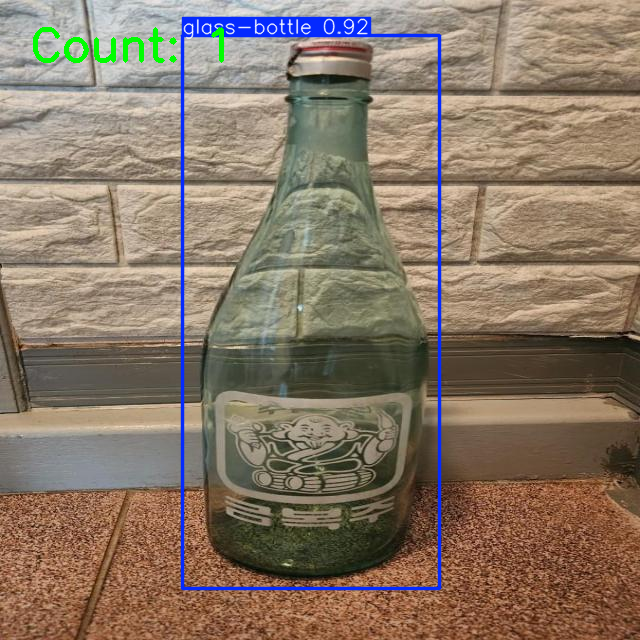


✅ SUCCESS: The model detected and counted 1 transparent objects.


In [ ]:
# Cell 5: Inference and Counting
import cv2
import glob
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# 1. Select a random image from the Validation set to test
# (These are images the model has NEVER seen before)
test_images = glob.glob(f'{base_dir}/valid/images/*.jpg') + glob.glob(f'{base_dir}/valid/images/*.png')

if len(test_images) > 0:
    # Pick the first image
    source_img = test_images[0]

    print(f"Testing on image: {source_img}")

    # 2. Run Prediction
    # conf=0.25: Only accept detections with > 25% confidence
    # iou=0.5:  prevents overlapping boxes on the same object
    results = model.predict(source_img, conf=0.25, iou=0.5, save=True)

    # 3. Process and Display Results
    for result in results:
        # Get the count of detected boxes
        object_count = len(result.boxes)

        # Plot the boxes on the image
        # line_width=2 makes the boxes thicker
        plotted_img = result.plot(line_width=2)

        # Add the "Count" text to the top-left corner
        cv2.putText(plotted_img, f"Count: {object_count}", (30, 60),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3)

        # Display using Colab's special imshow
        cv2_imshow(plotted_img)

        print(f"\n✅ SUCCESS: The model detected and counted {object_count} transparent objects.")
else:
    print("No validation images found. Please check your dataset folder.")

Phase 6: Save The Model

In [ ]:
# Cell 6: Download the trained weights
from google.colab import files

# The best weights are saved in runs/detect/transparent_object_detector/weights/best.pt
best_weight_path = '/content/runs/detect/transparent_object_detector/weights/best.pt'

if os.path.exists(best_weight_path):
    files.download(best_weight_path)
    print("Download started for 'best.pt'")
else:
    print("Training run not found. Did Phase 4 finish successfully?")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download started for 'best.pt'


Calculate Accuracy Metrics

In [ ]:
# Cell : Calculate Precision, Recall, and mAP
from ultralytics import YOLO

# Load the trained model
model_path = '/content/runs/detect/transparent_object_detector/weights/best.pt'

try:
    model = YOLO(model_path)

    # Run validation
    print("Evaluating model performance...")
    metrics = model.val()

    # Print key metrics
    print("\n" + "="*30)
    print(f"Mean Average Precision (mAP@50): {metrics.box.map50:.3f}")
    print(f"Mean Average Precision (mAP@50-95): {metrics.box.map:.3f}")
    print(f"Precision: {metrics.box.mp:.3f}")
    print(f"Recall: {metrics.box.mr:.3f}")
    print("="*30 + "\n")

except Exception as e:
    print(f"Error loading model: {e}")
    print("Check if the path '/content/runs/detect/transparent_object_detector/weights/best.pt' exists.")

Evaluating model performance...
Ultralytics 8.4.5 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 73 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1387.5±577.8 MB/s, size: 32.1 KB)
val: Scanning /content/Glass-bottles-2/valid/labels.cache... 750 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 750/750 165.6Mit/s 0.0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 197, len(boxes) = 1021. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 47/47 5.4it/s 8.6s
                   all        750       1021      0.945      0.934      0.969      0.791
Speed: 1.6ms preprocess, 3.8ms inference, 0.0ms loss, 1.6ms postprocess per image
Results sav

Visualize Training Graphs

### Confusion Matrix ###


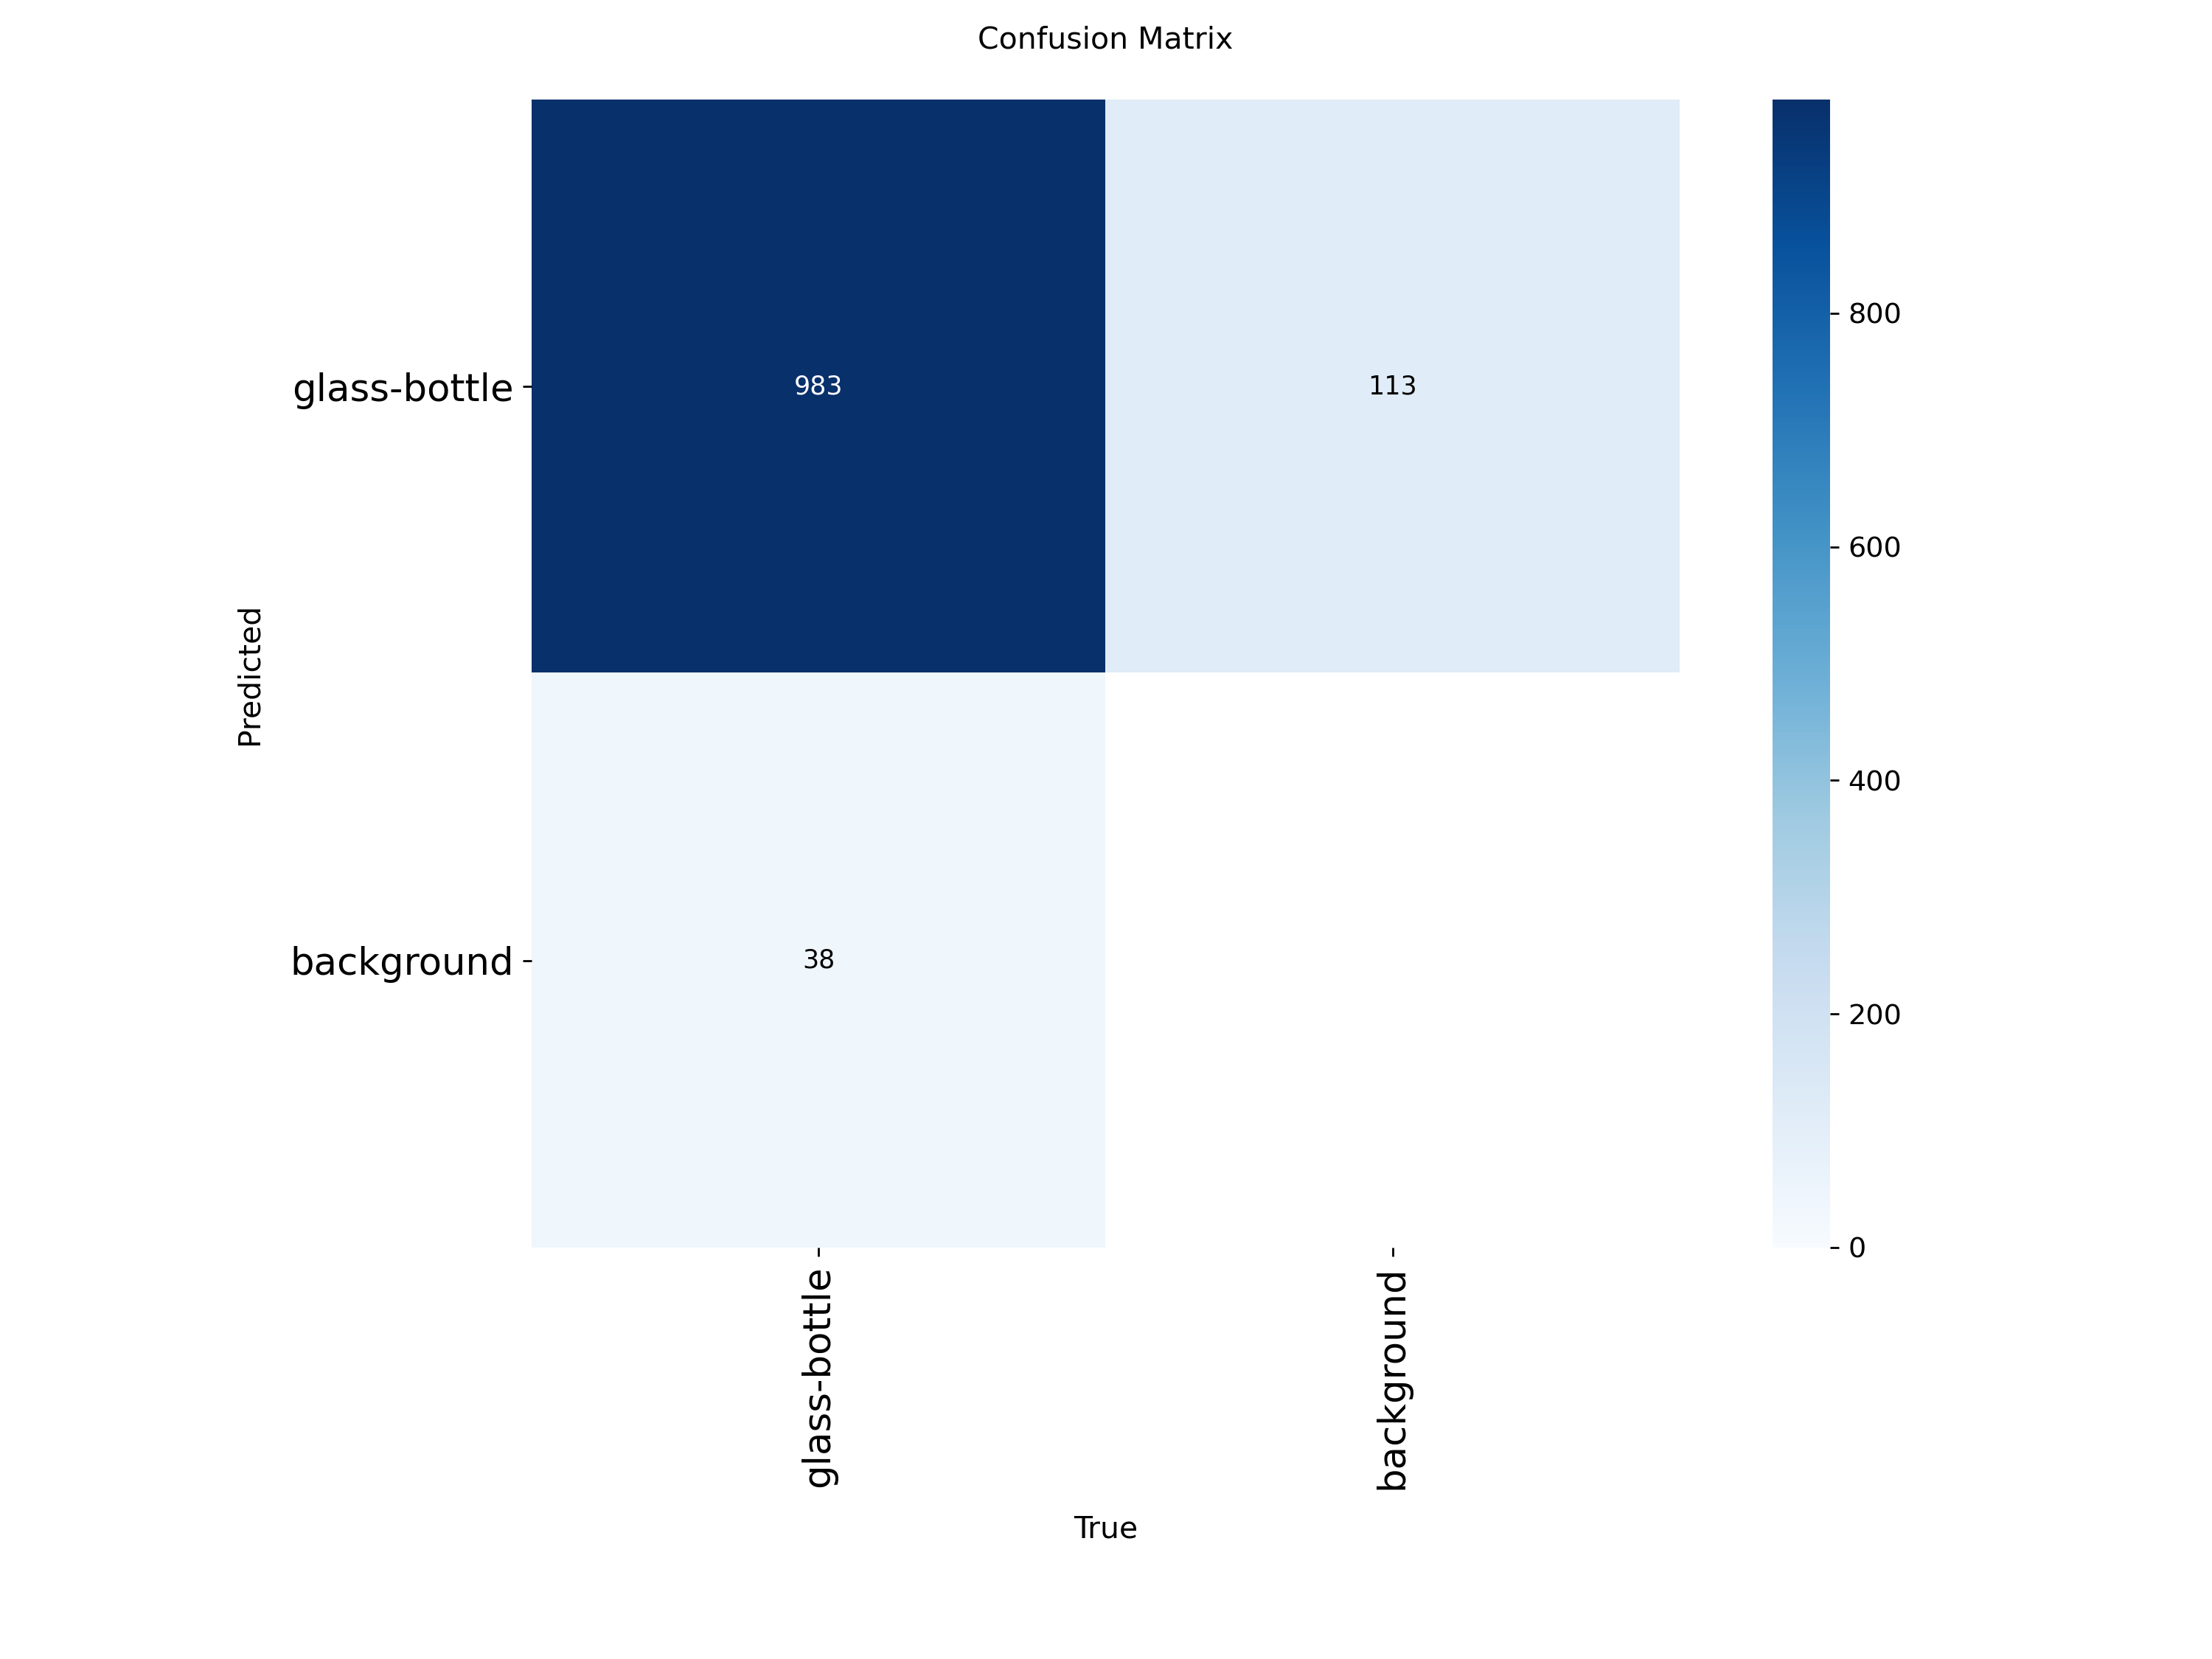


### Training Results (Loss & Accuracy) ###


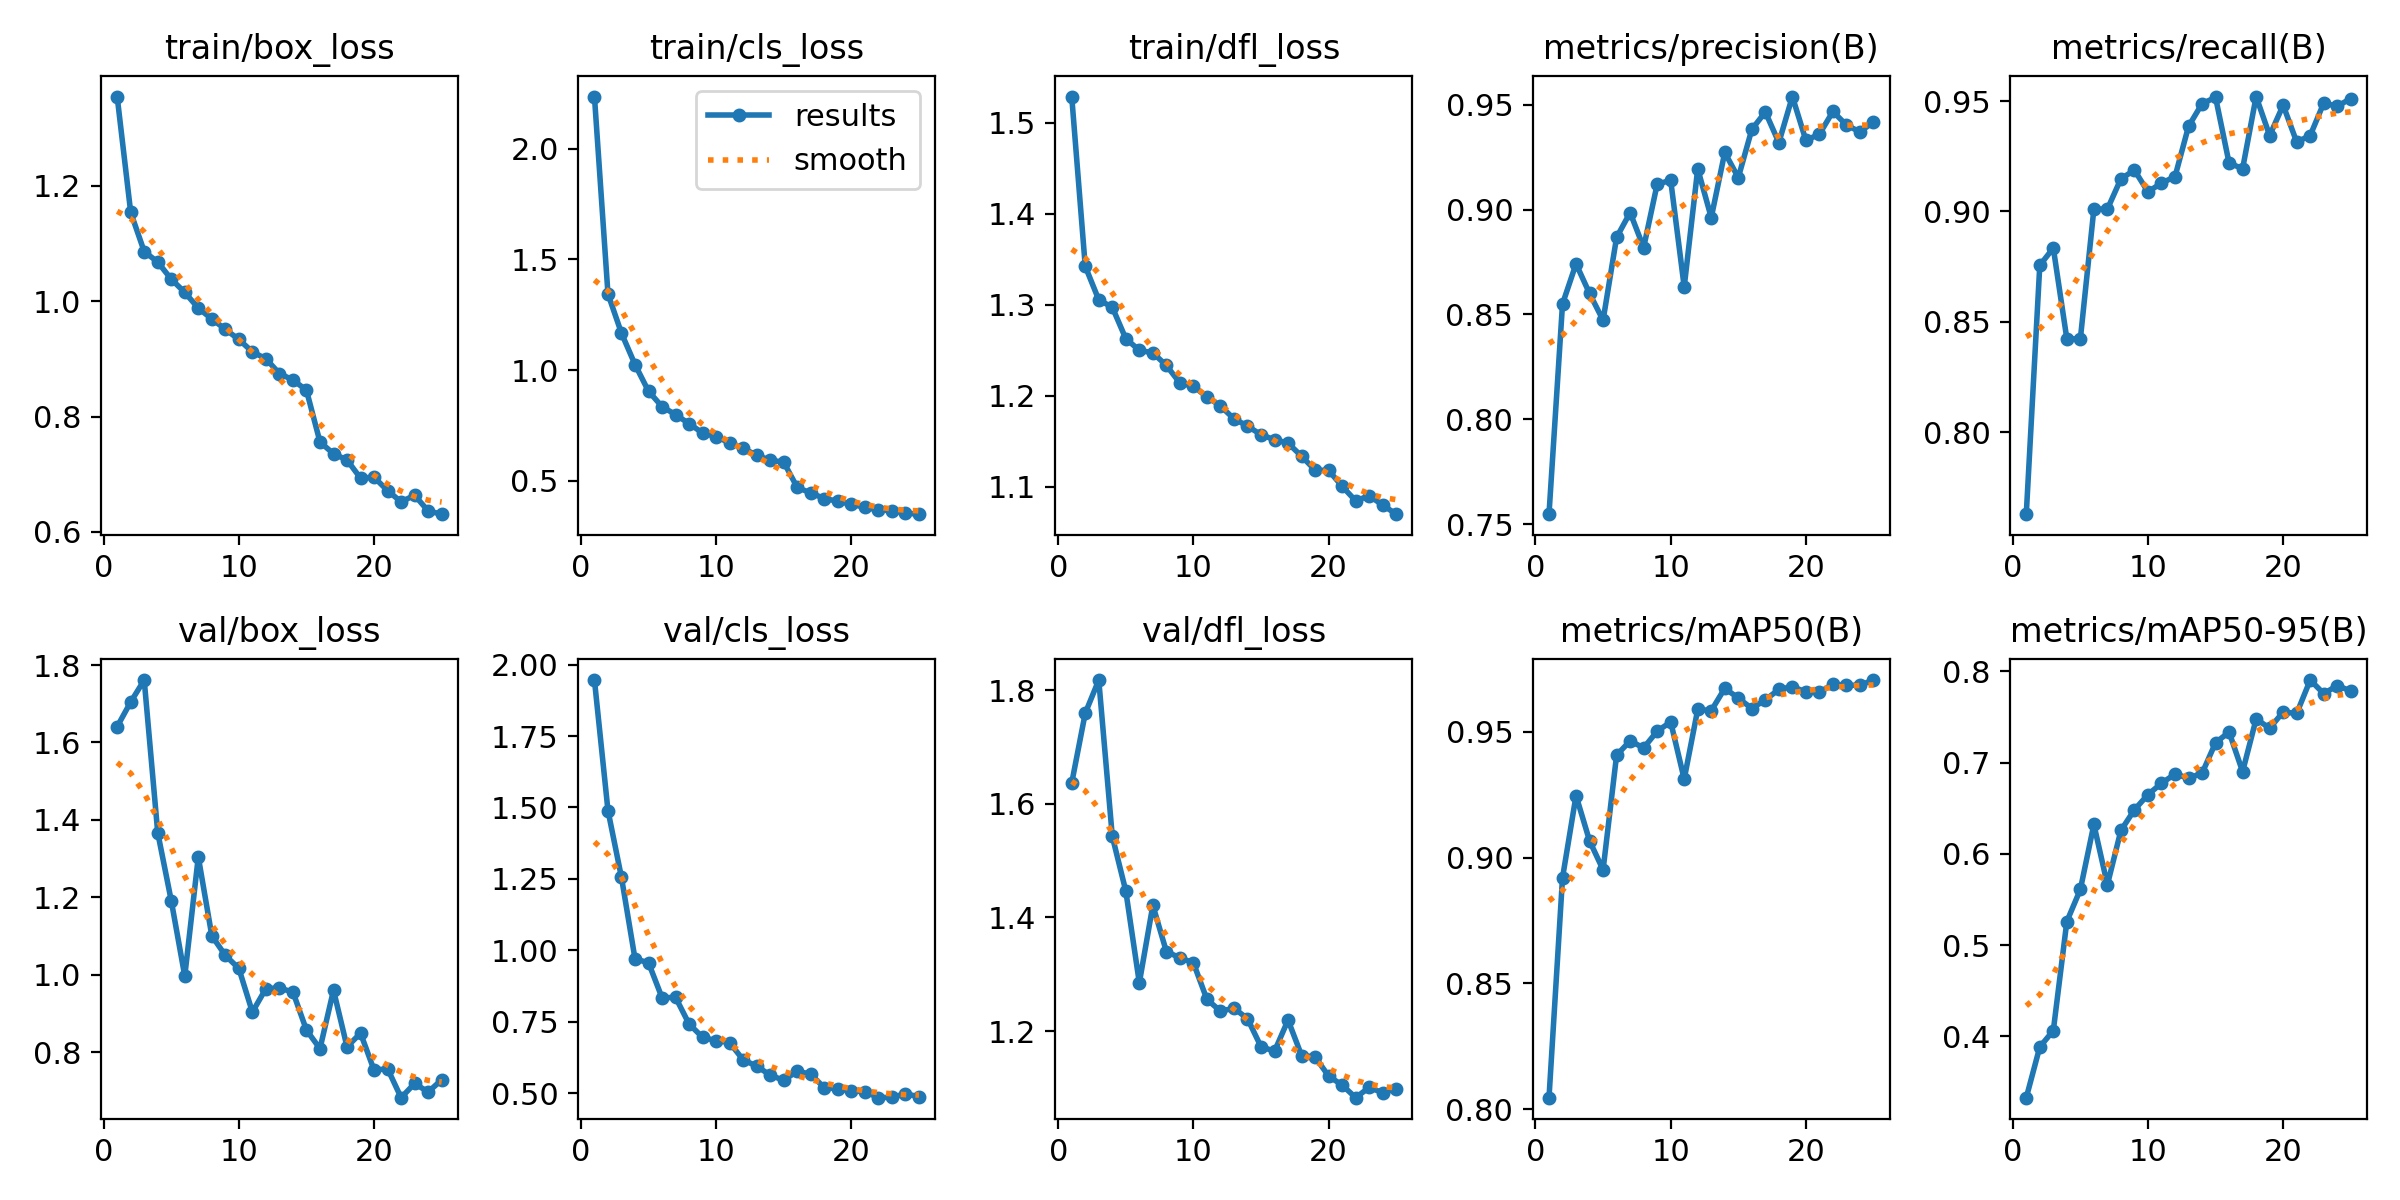

In [ ]:
# Cell : Display Training Graphs
import os
from IPython.display import Image, display

# Path to the run directory
run_dir = '/content/runs/detect/transparent_object_detector'

# 1. Confusion Matrix
# Shows how often the model confused 'Glass' with 'Background' (Missed detection)
cm_path = f'{run_dir}/confusion_matrix.png'
if os.path.exists(cm_path):
    print("### Confusion Matrix ###")
    display(Image(filename=cm_path, width=600))
else:
    print("Confusion matrix not found.")

# 2. Results Curve (Loss and Accuracy over time)
results_path = f'{run_dir}/results.png'
if os.path.exists(results_path):
    print("\n### Training Results (Loss & Accuracy) ###")
    display(Image(filename=results_path, width=800))
else:
    print("Results graph not found.")

In [ ]:
# Cell : Export Project Results
import shutil
from google.colab import files

# Compress the 'runs' folder which contains your Model, Graphs, and Logs
shutil.make_archive('transparent_object_project', 'zip', '/content/runs')

# Download the zip file
files.download('transparent_object_project.zip')

print("✅ Download started. This zip file contains:")
print("1. weights/best.pt (Your trained AI)")
print("2. results.png (The loss curves for your report)")
print("3. confusion_matrix.png (Proof of accuracy)")
print("4. val_batch0_pred.jpg (Visual proof of detections)")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Download started. This zip file contains:
1. weights/best.pt (Your trained AI)
2. results.png (The loss curves for your report)
3. confusion_matrix.png (Proof of accuracy)
4. val_batch0_pred.jpg (Visual proof of detections)


The "Live Upload" Demo

In [ ]:
# Cell for Demonstration: Live Upload & Count
from google.colab import files
from ultralytics import YOLO
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import os

# 1. Load your best trained model
# Check if the path is correct (it might be in a zip if you re-uploaded, or in runs/)
model_path = '/content/runs/detect/transparent_object_detector/weights/best.pt'

if not os.path.exists(model_path):
    print("⚠️ Model not found! Please check path or upload 'best.pt' manually.")
else:
    model = YOLO(model_path)
    print("✅ Model loaded successfully. Ready for demo.")

    # 2. Upload Widget
    print("\nPlease upload an image (jpg/png) to test...")
    uploaded = files.upload()

    for fn in uploaded.keys():
        # Read the uploaded image
        file_bytes = np.frombuffer(uploaded[fn], dtype=np.uint8)
        img = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)

        # 3. Run Inference
        # conf=0.4: We use slightly higher confidence for the demo to avoid glitches
        results = model.predict(img, conf=0.4, iou=0.5)

        for result in results:
            # Count boxes
            count = len(result.boxes)

            # Draw boxes
            plotted_img = result.plot(line_width=3, font_size=2)

            # Add a big "COUNT" label
            cv2.putText(plotted_img, f"COUNT: {count}", (50, 80),
                        cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 4)

            # Display
            print(f"\nProcessing {fn}...")
            cv2_imshow(plotted_img)